In [2]:
pg_sql_query = """
    WITH MaxDeliveryDates AS (
      SELECT
        so.id AS supplier_order_id,
        MAX(s.rc_delivered_ts) AS max_rc_delivered_ts,
        MAX(so.rc_accepted_ts) AS max_rc_accepted_ts
      FROM order_service.Supplier_Order so
      LEFT JOIN order_service.cargo_unit cu ON so.id = cu.supplier_order_id
      LEFT JOIN order_service.cargo_unit_shipment cus ON cu.id = cus.cargo_unit_id
      LEFT JOIN order_service.shipment s ON cus.shipment_id = s.id
      WHERE s.shipment_type = 'to_rc'
      GROUP BY so.id
    ),
    
    cat as (    
        select
           m.id,
           m.name,
           rc.top_name as top_category_name,
           rc.name as category_name
        from
           pim_catalog.model m
        left outer join (
                with recursive categories (id, parent_id, name, top_id, top_name) as (
                    select id, parent_id, name, id, name
                    from pim_catalog.category
                    where parent_id is null
                union all
                    select c.id, c.parent_id, c.name, top_id, top_name
                    from pim_catalog.category c
                    join categories r on r.id = c.parent_id
                )
                select * from categories
            ) rc on (m.category_id = rc.id)
    )
    
    
    SELECT
        so.id,
        so.supplier_id,
        so.catalog_id,
        oi.model_id,
        cat.name model_name,
        cat.category_name,
        cat.top_category_name,
        so.cost_net + coalesce(so.delivery_cost, 0) full_gmv,
        oi.quantity * (oi.unit_price + coalesce(oi.unit_delivery_price, 0)) model_gmv,
        c.name client_name,
        be.legal_entity,
        b2.name AS RC_name,
        so.create_ts,
        so.ready_ts,
        so.date_delivery rc_plan_delivery_date,
        CASE WHEN EXTRACT(ISODOW FROM so.date_delivery) IN (6, 7) THEN so.date_delivery + INTERVAL '4 days' ELSE so.date_delivery + INTERVAL '2 days' END AS adjusted_plan_delivery_date,
        so.rc_accepted_ts, 
        max_rc_delivered_ts,
        so.system_status,
        
        -- проверка на опоздание для rc_accepted
        (CASE WHEN EXTRACT(ISODOW FROM date_delivery) IN (6,7) THEN date_delivery + '4 days'::interval ELSE date_delivery + '2 days'::interval END) < CASE WHEN system_status IN ('SHIPPED', 'PACKED', 'READY') THEN NOW() ELSE rc_accepted_ts END AS is_late_to_rc_accepted,
        
        -- проверка на опоздание для rc_delivered
        (CASE WHEN EXTRACT(ISODOW FROM date_delivery) IN (6,7) THEN date_delivery + '4 days'::interval ELSE date_delivery + '2 days'::interval END) < CASE WHEN system_status IN ('SHIPPED', 'PACKED', 'READY') THEN NOW() ELSE COALESCE(max_rc_delivered_ts, rc_accepted_ts) END AS is_late_to_rc_delivered,
    
        -- за сколько планировалось доставить
        CEIL(EXTRACT(EPOCH FROM (CASE WHEN EXTRACT(ISODOW FROM date_delivery) IN (6,7) THEN date_delivery + INTERVAL '4 days' ELSE date_delivery + INTERVAL '2 days' END - so.create_ts)))/86400 AS planned_days,
    
        -- за сколько доставили
        CEIL(EXTRACT(EPOCH FROM (so.rc_accepted_ts - so.create_ts)) / 86400) AS actual_days,
        
        DENSE_RANK() OVER (
            ORDER BY so.supplier_id, b2.name, DATE_TRUNC('day', so.rc_accepted_ts)
        ) AS cluster_id,
        
        FLOOR(EXTRACT(EPOCH FROM (
            MAX(so.ready_ts) OVER (PARTITION BY so.supplier_id, b2.name, DATE_TRUNC('day', so.rc_accepted_ts)) 
            - MIN(so.ready_ts) OVER (PARTITION BY so.supplier_id, b2.name, DATE_TRUNC('day', so.rc_accepted_ts))
        )) / 86400) AS form_days,
    
        so.available as stored
    
    FROM order_service.order_item oi 
    LEFT JOIN order_service.supplier_order so ON oi.supplier_order_id = so.id 
    LEFT JOIN order_service.Order o ON oi.order_id = o.id
    LEFT JOIN client_service.basis b ON b.id = o.basis_id
    LEFT JOIN client_service.business_entity be ON be.id = b.be_id
    LEFT JOIN dictionary_service.distribution_center b2 ON CASE 
        WHEN so.distribution_center_id IS NOT NULL THEN so.distribution_center_id = b2.id 
        ELSE o.distribution_basis_id = b2.id 
    END
    LEFT JOIN client_service.client c ON o.client_id = c.id 
    LEFT JOIN cat ON oi.model_id = cat.id
    LEFT JOIN MaxDeliveryDates mdd ON mdd.supplier_order_id = so.id
    WHERE system_status NOT IN ('CANCELED', 'DRAFT', 'DECLINED', 'WAITING', 'RETURNED', 'ACCEPTED')
    AND so.create_ts > '06.01.2024'
    AND so.rc_accepted_ts IS NOT NULL
    AND so.ready_ts IS NOT NULL
    and max_rc_delivered_ts != so.rc_accepted_ts
    and max_rc_delivered_ts is not null
    order by so.supplier_id, b2.name, DATE_TRUNC('day', so.rc_accepted_ts), so.ready_ts 
""""

SyntaxError: unterminated string literal (detected at line 101) (2538642267.py, line 101)

In [1]:
import pandas as pd
import warnings

# Отключить все предупреждения
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('rc_delays_26.06.csv')

In [5]:
df.head(5)

,id,supplier_id,catalog_id,model_id,model_name,category_name,top_category_name,full_gmv,model_gmv,client_name,...,rc_accepted_ts,max_rc_delivered_ts,system_status,is_late_to_rc_accepted,is_late_to_rc_delivered,planned_days,actual_days,cluster_id,form_days,stored
0,54238,1,1,1856778,"Комплект проводов прикуривания 300 А, 2,5 м, 1...",Пусковые провода,Автотовары и запчасти,833,833.0,"ПАО ""Полюс""",...,2024-08-23 12:16:02,2024-08-21 13:01:16,DELIVERED,False,False,65,52,1,0,False
1,49786,1,710,836,Кувалда кованая Профи с фибергласовой обрезине...,Кувалда,Строительство и ремонт,2871,2871.0,"ПАО ""Полюс""",...,2024-09-03 15:33:51,2024-08-21 13:01:43,DELIVERED,True,True,71,85,2,0,False
2,50596,1,356,670838,Строп СТП-СТП-15/10000 РД 24-СЗК-01-01,Стропы текстильные,Строительство и ремонт,26773,26773.0,"ПАО ""Полюс""",...,2024-09-25 11:39:36,2024-08-21 13:01:36,DELIVERED,True,False,76,101,3,0,False
3,131121,1,1829,199737,Молоток отбойный пневматический МОП-3,Пневматический молоток,Строительство и ремонт,422431,422431.0,"ПАО ""Полюс""",...,2025-04-30 11:46:16,2025-04-30 11:46:16,DELIVERED,True,True,50,79,4,36,True
4,142728,1,1829,1494603,Машина поломоечная TOR MINI 350 с АКБ,Поломоечные машины,Профессиональное оборудование,309086,309086.0,"ПАО ""Полюс""",...,2025-04-30 11:43:49,2025-04-30 11:43:49,DELIVERED,True,True,21,56,4,36,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43066 entries, 0 to 43065
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           43066 non-null  int64  
 1   supplier_id                  43066 non-null  int64  
 2   catalog_id                   43066 non-null  int64  
 3   model_id                     43066 non-null  int64  
 4   model_name                   43066 non-null  object 
 5   category_name                43066 non-null  object 
 6   top_category_name            43066 non-null  object 
 7   full_gmv                     43066 non-null  int64  
 8   model_gmv                    43066 non-null  float64
 9   client_name                  43066 non-null  object 
 10  legal_entity                 43066 non-null  object 
 11  rc_name                      43066 non-null  object 
 12  create_ts                    43066 non-null  object 
 13  ready_ts        

In [9]:
df.describe()

,id,supplier_id,catalog_id,model_id,full_gmv,model_gmv,planned_days,actual_days,cluster_id,form_days
count,43066.000000,43066.000000,43066.000000,4.306600e+04,4.306600e+04,4.306600e+04,43066.000000,43066.000000,43066.000000,43066.000000
mean,125849.122463,783.508870,958.343148,8.803404e+05,6.745385e+04,2.621541e+04,40.011262,45.402800,2687.234570,39.544211
std,39899.044402,934.461082,859.291896,7.406730e+05,2.829404e+05,1.478971e+05,27.546642,41.656958,2249.211815,46.000544
min,47821.000000,1.000000,1.000000,2.600000e+01,7.000000e+00,2.200000e-01,2.000000,1.000000,1.000000,0.000000
25%,92714.500000,18.000000,143.000000,2.208865e+05,5.043250e+03,1.305000e+03,22.000000,19.000000,692.000000,6.000000
50%,131953.000000,304.000000,850.000000,5.278390e+05,1.435700e+04,3.899000e+03,32.000000,31.000000,2048.000000,21.000000
75%,162298.000000,1545.000000,1818.000000,1.501624e+06,4.265375e+04,1.354575e+04,52.000000,58.000000,4978.000000,60.000000
max,182034.000000,3744.000000,3368.000000,2.800771e+06,9.400235e+06,8.365430e+06,434.000000,366.000000,6777.000000,336.000000


In [11]:
df['ready_ts'] = pd.to_datetime(df['ready_ts'])
df['rc_accepted_ts'] = pd.to_datetime(df['rc_accepted_ts'])
df['adjusted_plan_delivery_date'] = pd.to_datetime(df['adjusted_plan_delivery_date'])

In [13]:
# Создаем DataFrame с уникальными cluster_id и соответствующим им consolidated_cluster
cluster_consolidation = (
    df[['cluster_id', 'form_days']]
    .drop_duplicates()
    .assign(consolidated_cluster=lambda x: x['form_days'] > 3)
)

# Присоединяем по cluster_id
df = df.merge(cluster_consolidation[['cluster_id', 'consolidated_cluster']], on='cluster_id', how='left')

In [15]:
# ABC-классификация по model_gmv
supplier_gmv = (
    df.groupby('supplier_id', as_index=False)
    .agg(total_gmv=('model_gmv', 'sum'))
    .sort_values('total_gmv', ascending=False, ignore_index=True)
)

supplier_gmv['cumulative_percent'] = (supplier_gmv['total_gmv'].cumsum() / supplier_gmv['total_gmv'].sum()) * 100
supplier_gmv['abc_category'] = supplier_gmv['cumulative_percent'].apply(
    lambda x: 'A' if x <= 70 else 'B' if x <= 90 else 'C'
)

df = df.merge(supplier_gmv[['supplier_id', 'abc_category']], on='supplier_id', how='left')

In [17]:
df['abc_category'].value_counts()

abc_category
A    32225
B     7599
C     3242
Name: count, dtype: int64

In [19]:
df.groupby('abc_category')['supplier_id'].nunique()

abc_category
A     44
B     59
C    176
Name: supplier_id, dtype: int64

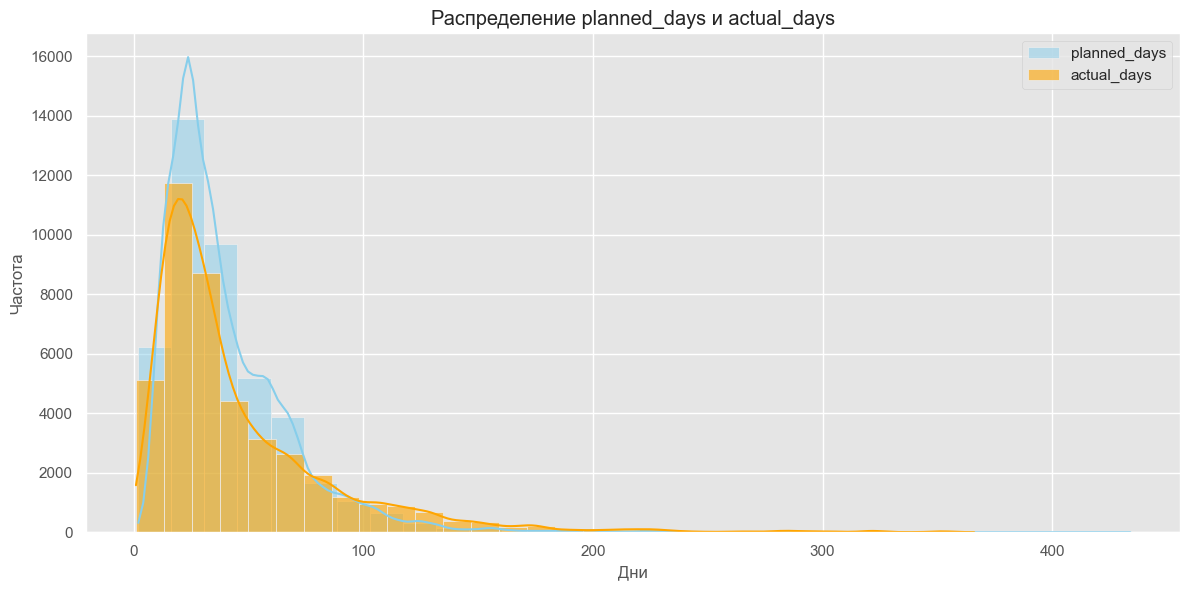

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения графиков
sns.set(style='whitegrid')
plt.style.use('ggplot')

# 1. Распределение planned_days и actual_days
plt.figure(figsize=(12, 6))
sns.histplot(df['planned_days'], bins=30, kde=True, color='skyblue', label='planned_days')
sns.histplot(df['actual_days'], bins=30, kde=True, color='orange', alpha=0.6, label='actual_days')
plt.title('Распределение planned_days и actual_days')
plt.xlabel('Дни')
plt.ylabel('Частота')
plt.legend()
plt.tight_layout()
plt.show()

## Плановое (planned_days) время имеет заметный пик в сравнении с фактическим (actual_days) временем

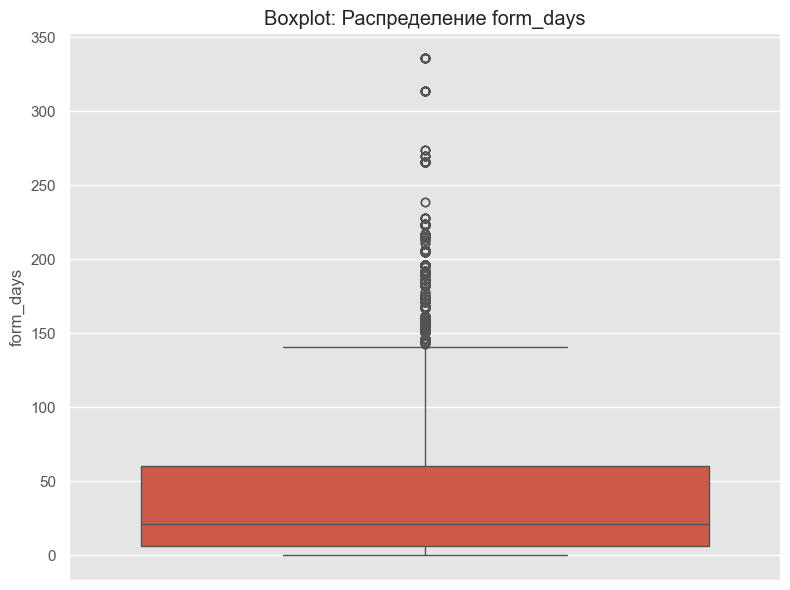

In [23]:
# 2. Boxplot по form_days
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['form_days'])
plt.title('Boxplot: Распределение form_days')
plt.ylabel('form_days')
plt.tight_layout()
plt.show()

## В распределении времени формирования (form_days) - заметны явные выбросы

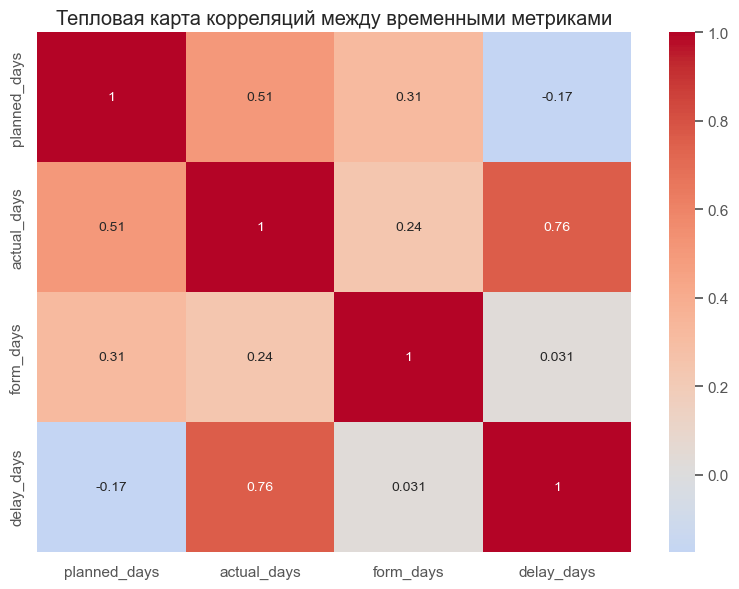

In [27]:
# 3. Тепловая карта корреляций
df['delay_days'] = df['actual_days'] - df['planned_days']
corr = df[['planned_days', 'actual_days', 'form_days', 'delay_days']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Тепловая карта корреляций между временными метриками')
plt.tight_layout()
plt.show()

## Опоздания (delay_days) почти не коррелируют с временем консолидации (form_days)

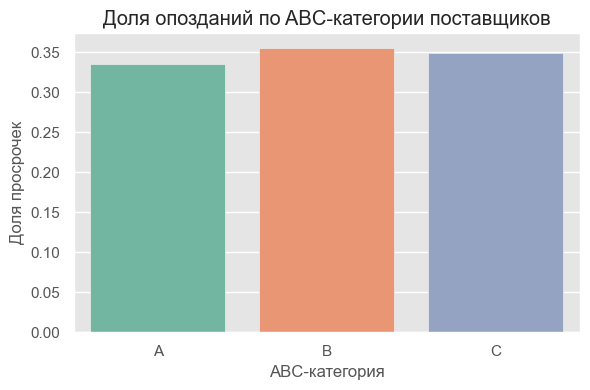

In [30]:
# 4. Доля просрочек (is_late_to_rc_delivered) по abc_category
late_by_abc = df.groupby('abc_category')['is_late_to_rc_delivered'].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(x='abc_category', y='is_late_to_rc_delivered', data=late_by_abc, palette='Set2')
plt.title('Доля опозданий по ABC-категории поставщиков')
plt.xlabel('ABC-категория')
plt.ylabel('Доля просрочек')
plt.tight_layout()
plt.show()

## Опоздания не так уж зависят от уровня поставщика.

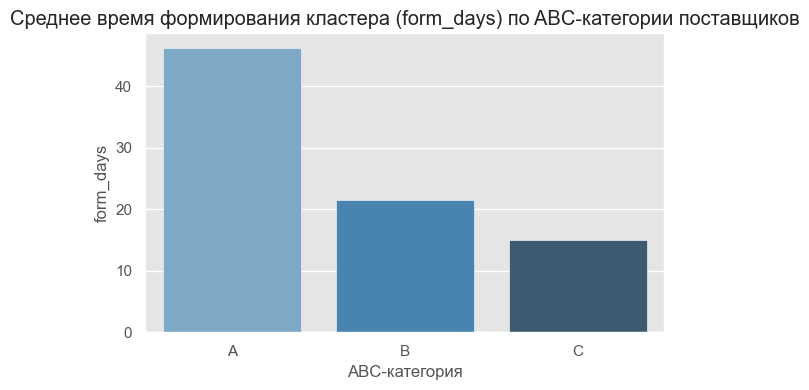

In [33]:
# 5. Среднее значение form_days по abc_category
avg_form_by_abc = df.groupby('abc_category')['form_days'].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(x='abc_category', y='form_days', data=avg_form_by_abc, palette='Blues_d')
plt.title('Среднее время формирования кластера (form_days) по ABC-категории поставщиков')
plt.xlabel('ABC-категория')
plt.ylabel('form_days')
plt.tight_layout()
plt.show()

## Заметно, что чаще консолидируют подзаказы именно крупные поставщики.

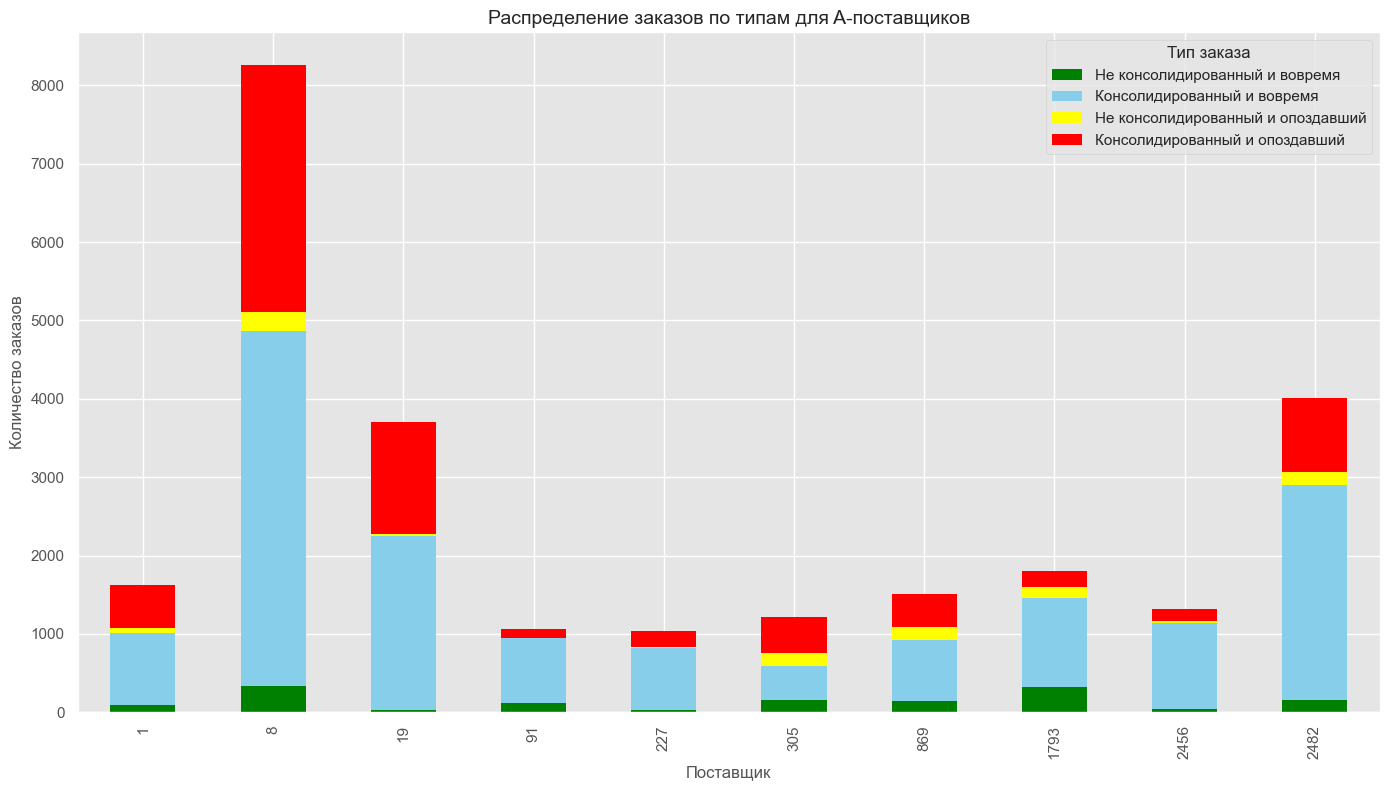

In [36]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 1. Фильтруем только A-поставщиков
df_top_orders = df[df.groupby('supplier_id').transform('size') > 1000]

# 2. Классифицируем заказы
def classify_order(row):
    if row['consolidated_cluster'] and row['is_late_to_rc_delivered']:
        return 'Консолидированный и опоздавший'
    elif not row['consolidated_cluster'] and row['is_late_to_rc_delivered']:
        return 'Не консолидированный и опоздавший'
    elif row['consolidated_cluster'] and not row['is_late_to_rc_delivered']:
        return 'Консолидированный и вовремя'
    else:
        return 'Не консолидированный и вовремя'

df_top_orders = df_top_orders.copy()
df_top_orders['order_category'] = df_top_orders.apply(classify_order, axis=1)

# 3. Группируем
category_counts = df_top_orders.groupby(['supplier_id', 'order_category']).size().unstack(fill_value=0)

# 4. Порядок столбцов и цвета
order = [
    'Не консолидированный и вовремя',
    'Консолидированный и вовремя',
    'Не консолидированный и опоздавший',
    'Консолидированный и опоздавший'
]

colors = {
    'Консолидированный и опоздавший': 'red',
    'Не консолидированный и опоздавший': 'yellow',
    'Консолидированный и вовремя': 'skyblue',
    'Не консолидированный и вовремя': 'green'
}

# 5. Строим график
plt.figure(figsize=(14, 8))
category_counts[order].plot(kind='bar', stacked=True, color=colors, edgecolor='none', ax=plt.gca())

plt.title("Распределение заказов по типам для A-поставщиков", fontsize=14)
plt.xlabel("Поставщик", fontsize=12)
plt.ylabel("Количество заказов", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title="Тип заказа")
plt.tight_layout()
plt.show()

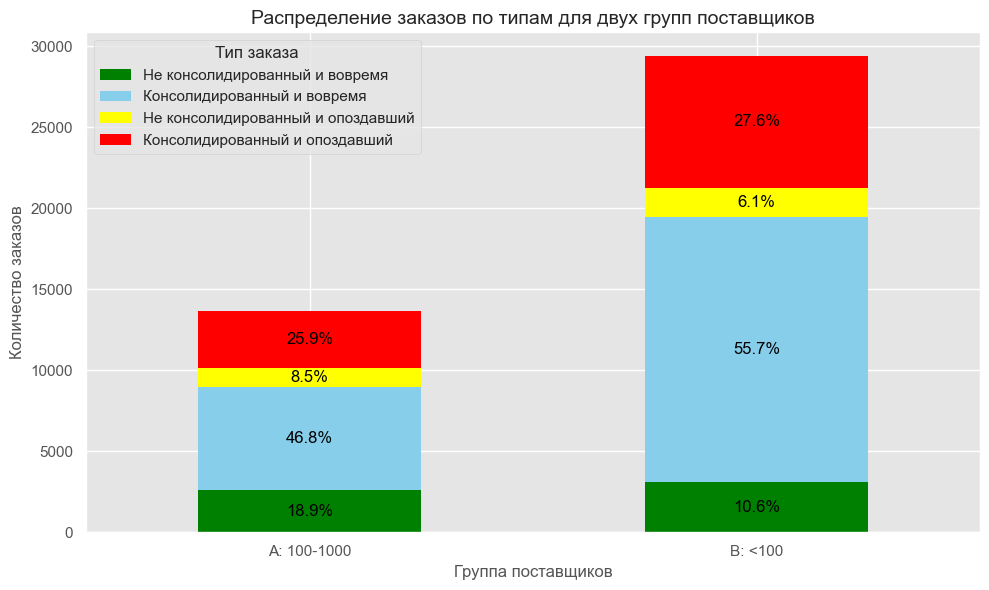

In [38]:
# Шаг 1: Проставляем количество заказов на поставщика
group_counts = df.groupby('supplier_id', as_index=False).size()

# Шаг 2: Проставляем группу каждому поставщику
def assign_group(row):
    if 100 <= row['size'] <= 1000:
        return 'A: 100-1000'
    else:
        return 'B: <100'

group_counts['group'] = group_counts.apply(assign_group, axis=1)

# Шаг 3: Добавляем группу в основной датафрейм
df_grouped = df.merge(group_counts[['supplier_id', 'group']], on='supplier_id', how='left')

# Шаг 4: Классифицируем заказы
df_grouped = df_grouped.copy()
df_grouped['order_category'] = df_grouped.apply(classify_order, axis=1)

# Шаг 5: Агрегируем данные по группам
category_by_group = (
    df_grouped[df_grouped['group'].isin(['A: 100-1000', 'B: <100'])]
    .groupby(['group', 'order_category'])
    .size()
    .unstack(fill_value=0)
)

# Убедимся, что все категории присутствуют в нужном порядке
category_by_group = category_by_group.reindex(columns=order)

# Шаг 6: Строим график с подписями %
plt.figure(figsize=(10, 6))
ax = category_by_group.plot(kind='bar', stacked=True, color=colors, edgecolor='none', ax=plt.gca())

plt.title("Распределение заказов по типам для двух групп поставщиков", fontsize=14)
plt.xlabel("Группа поставщиков", fontsize=12)
plt.ylabel("Количество заказов", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Тип заказа")
plt.tight_layout()

# Добавляем подписи процентов
for container in ax.containers:
    # Игнорируем "невидимые" контейнеры
    if isinstance(container, matplotlib.container.BarContainer):
        for bar in container.patches:
            # Получаем позицию и высоту бара
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + bar.get_height() / 2

            # Вычисляем процент от общего количества в этом столбце
            total = category_by_group.iloc[int(bar.get_x() / bar.get_width())].sum()
            percent = bar.get_height() / total * 100 if total != 0 else 0

            # Пишем текст
            if percent > 5:  # Чтобы не перегружать график, показываем только значимые доли
                ax.annotate(f'{percent:.1f}%', xy=(x, y), xytext=(0, 0),
                            textcoords='offset points', ha='center', va='center',
                            fontsize=12, color='black', weight='normal')

plt.show()

# **Цель первого этапа исследования**
Определить, существует ли статистически значимая связь между **консолидацией заказов** (измеряемой через `form_days`) и увеличением задержки доставки (`delay_days`).

---
### **Формулировка гипотез**
### **Нулевая гипотеза (H₀):**
Консолидация заказов в кластеры **не увеличивает задержки доставки (`delay_days`)**.  
- **Предположение:** Заказы, для которых `form_days > 3`, **не имеют значимо больших задержек** по сравнению с заказами, для которых `form_days ≤ 3`.

### **Альтернативная гипотеза (H₁):**
Консолидация заказов в кластеры увеличивает разницу между фактическим и запланированным временем доставки (`delay_days = actual_days - planned_days`), то есть увеличивает риск и величину опоздания.  
- **Предположение:** Чем дольше длится формирование грузоместа (`form_days`), тем больше вероятность того, что старые заказы в кластере будут иметь значимо большие задержки по сравнению с новыми заказами.

## Проверка гипотезы:

In [40]:
# Вычисляем delay_days
df['delay_days'] = df['actual_days'] - df['planned_days']

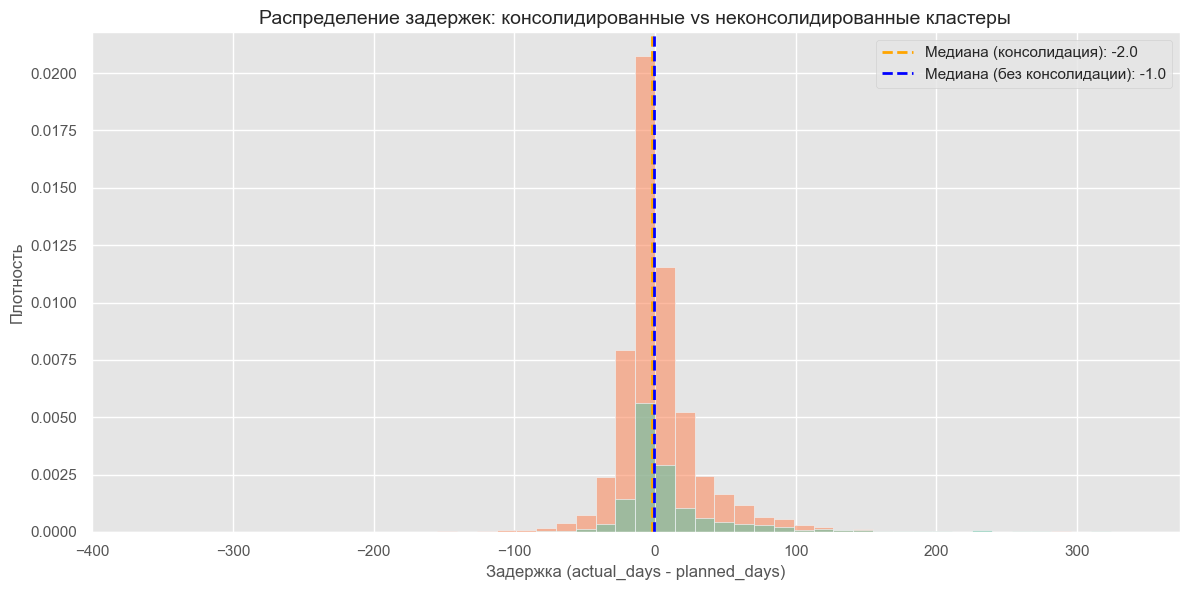

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x='delay_days',
    hue='consolidated_cluster',
    bins=50,
    alpha=0.6,
    palette='Set2',
    stat='density'
)

# Добавляем вертикальные линии средних
median_consolidated = df[df['consolidated_cluster']]['delay_days'].median()
median_not_consolidated = df[~df['consolidated_cluster']]['delay_days'].median()

plt.axvline(median_consolidated, color='orange', linestyle='--', linewidth=2, label=f'Медиана (консолидация): {median_consolidated:.1f}')
plt.axvline(median_not_consolidated, color='blue', linestyle='--', linewidth=2, label=f'Медиана (без консолидации): {median_not_consolidated:.1f}')

plt.title('Распределение задержек: консолидированные vs неконсолидированные кластеры', fontsize=14)
plt.xlabel('Задержка (actual_days - planned_days)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Медианы идентичные.
    Провожу U-test, ибо считаю, что выборки имеют "хвосты"

In [65]:
from scipy.stats import mannwhitneyu

# Шаг 1: Формируем группы на основе consolidated_cluster
group_non_consolidated = df[~df['consolidated_cluster']]['delay_days']
group_consolidated = df[df['consolidated_cluster']]['delay_days']

# Шаг 2: Тест Манна-Уитни
result = mannwhitneyu(group_non_consolidated, group_consolidated, alternative='less')

# Интерпретация результата
if result.pvalue < 0.05:
    significance = "статистически значимо"
else:
    significance = "статистически незначимо"

print(f"U-статистика: {result.statistic}, p-значение: {result.pvalue:.3f} ({significance})")

U-статистика: 163472486.5, p-значение: 1.000 (статистически незначимо)


### Результат тесте не является статистически значимым
Отвергнуть нулевую гипотезу невозможно. Консолидация заказов в кластеры **не увеличивает задержки доставки (`delay_days`)**. 

# Итог:
    Альтернативная гипотеза, что консолидация приводит к бОльшим задержкам - не подтверждается.
    Консолидация заказов, как таковая, не приводит к увеличению сроков поставки.

# **Цель второго этапа исследования**
Определить, влияет ли консолидация заказов на задержки доставки **"старых" заказов в кластере**, и выявить пороговое значение `form_days`, после которого задержки становятся критическими.

---

### **Формулировка гипотез**

#### **Основная гипотеза (H₀):**
- Консолидация заказов **не увеличивает задержки доставки "старых" заказов** в кластере.
- То есть: Задержки для "старых" заказов (`delay_days`) не зависят от длительности формирования грузоместа (`form_days`).

#### **Альтернативная гипотеза (H₁):**
- Консолидация заказов **увеличивает задержки доставки "старых" заказов** в кластере.
- То есть: Чем дольше длится формирование грузоместа (`form_days`), тем больше вероятность значимо больших задержек для "старых" заказов.

In [67]:
filtered_df = df[df['form_days'] > 3]

# Находим "старые" заказы (минимальная ready_ts)
old_orders = (filtered_df.loc[filtered_df.groupby('cluster_id')['ready_ts'].idxmin()])

# Находим "новые" заказы (максимальная ready_ts)
new_orders = (filtered_df.loc[filtered_df.groupby('cluster_id')['ready_ts'].idxmax()])

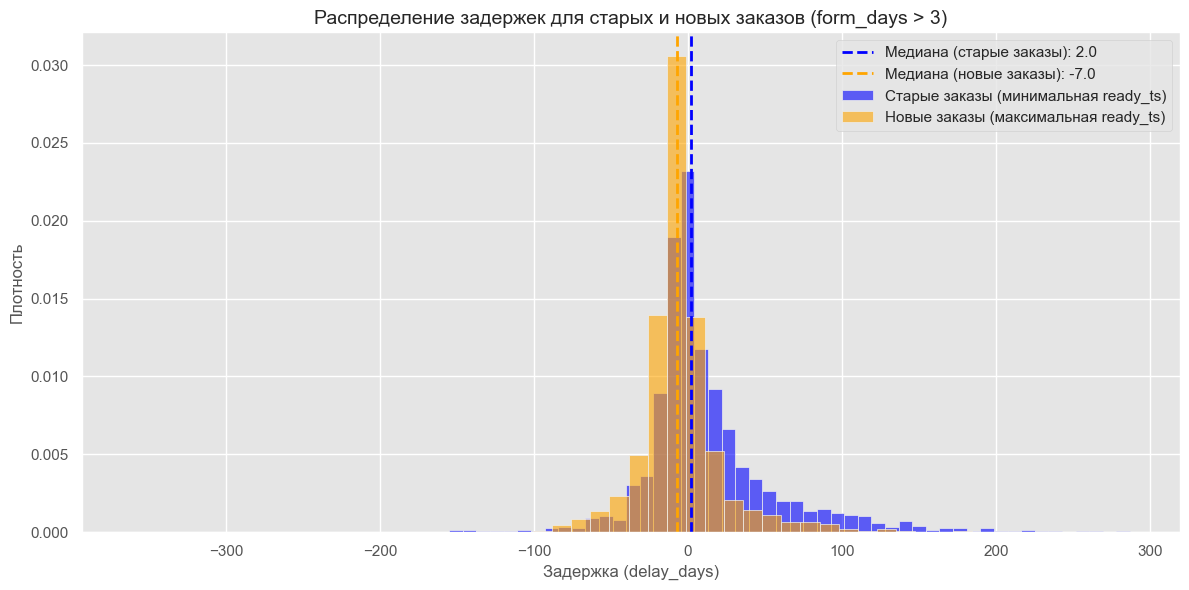

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Гистограмма для "старых" заказов
sns.histplot(
    old_orders['delay_days'],
    bins=50,
    color='blue',
    alpha=0.6,
    label='Старые заказы (минимальная ready_ts)',
    stat='density'
)

# Гистограмма для "новых" заказов
sns.histplot(
    new_orders['delay_days'],
    bins=50,
    color='orange',
    alpha=0.6,
    label='Новые заказы (максимальная ready_ts)',
    stat='density'
)

# Вычисляем медианы
median_old = old_orders['delay_days'].median()
median_new = new_orders['delay_days'].median()

# Добавляем вертикальные линии для медиан
plt.axvline(median_old, color='blue', linestyle='--', linewidth=2, label=f'Медиана (старые заказы): {median_old:.1f}')
plt.axvline(median_new, color='orange', linestyle='--', linewidth=2, label=f'Медиана (новые заказы): {median_new:.1f}')

# Добавляем заголовок и метки осей
plt.title('Распределение задержек для старых и новых заказов (form_days > 3)', fontsize=14)
plt.xlabel('Задержка (delay_days)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)

# Добавляем легенду и сетку
plt.legend()
plt.grid(True)
plt.tight_layout()

# Показываем график
plt.show()

In [71]:
# Шаг 1: Формируем группы
group_old = old_orders['delay_days']
group_new = new_orders['delay_days']

# Шаг 2: Тест Манна-Уитни (односторонний)
result = mannwhitneyu(group_old, group_new, alternative='greater')

# Интерпретация результата
if result.pvalue < 0.05:
    significance = "статистически значимо"
else:
    significance = "статистически незначимо"

print(f"U-статистика: {result.statistic}, p-значение: {result.pvalue:.3f} ({significance})")

U-статистика: 3998966.0, p-значение: 0.000 (статистически значимо)


# **Вывод:**  
- Консолидация заказов **увеличивает задержки доставки "старых" заказов** в кластере. Различия между задержками для "старых" и "новых" заказов статистически значимы (p-значение = 0.000).  

### Это подтверждает альтернативную гипотезу о влиянии консолидации на задержки "старых" заказов.

# **Цель третьего этапи исследования:**
1. Определить пороговое значение `form_days`,начиная с которого задержки доставки (`delay_days`) для первых заказов в кластерах становятся статистически значимо больше по сравнению с задержками для первых заказов в кластерах с меньшими значениями (`delay_days`).

In [75]:
# Находим первые заказы в каждом кластере (минимальная ready_ts)
first_orders = (df.loc[df.groupby('cluster_id')['ready_ts'].idxmin()])

# Фильтруем первые заказы для консолидированных кластеров (form_days > 3)
first_orders_consolidated = first_orders[first_orders['form_days'] > 3]

# Проверяем размер выборки
print(f"Количество первых заказов в консолидированных кластерах: {len(first_orders_consolidated)}")

# Выводим первые строки
first_orders_consolidated.head(3)

Количество первых заказов в консолидированных кластерах: 2469


,id,supplier_id,catalog_id,model_id,model_name,category_name,top_category_name,full_gmv,model_gmv,client_name,...,is_late_to_rc_accepted,is_late_to_rc_delivered,planned_days,actual_days,cluster_id,form_days,stored,consolidated_cluster,abc_category,delay_days
3,131121,1,1829,199737,Молоток отбойный пневматический МОП-3,Пневматический молоток,Строительство и ремонт,422431,422431.0,"ПАО ""Полюс""",...,True,True,50,79,4,36,True,True,A,29
6,128104,1,1,675895,"Кронштейн транспортный KTX-5+, усиленный с мет...","Держатели и подставки для огнетушителей, гидра...",Строительство и ремонт,129001,129000.0,"ПАО ""Полюс""",...,True,True,84,91,5,54,False,True,A,7
22,126721,1,1,1364,Парусина полульняная (брезент) 11293СКПВ плотн...,Техническая ткань,Хозтовары и посуда,18273,18273.0,"ПАО ""Полюс""",...,True,True,55,103,6,75,False,True,A,48


## Цикл поиска порога 'form_days' с учётом мощности теста:

In [78]:
# Отфильтруем данные для анализа (form_days > 3)
consolidated_data = df[df['form_days'] > 3]

# Этап 1: Определяем начальные параметры
threshold = 3  # Начальный порог form_days
step = 3       # Шаг увеличения порога
target_power = 0.9  # Целевая мощность теста
found_threshold = None  # Переменная для хранения найденного порога

# Этап 2: Цикл для увеличения порога
while found_threshold is None:
    threshold += step  # Увеличиваем порог
    
    # Фильтруем данные для текущего порога
    group_current = consolidated_data[consolidated_data['form_days'] <= threshold]['delay_days']
    group_baseline = first_orders_consolidated['delay_days']
    
    # Проверяем размер выборок
    if len(group_current) == 0 or len(group_baseline) == 0:
        print(f"Недостаточно данных для порога form_days ≤ {threshold}. Продолжаем...")
        continue
    
    # Тест Манна-Уитни
    result = mannwhitneyu(group_baseline, group_current, alternative='greater')
    
    # Рассчитываем размер эффекта (Cohen's d)
    mean_diff = group_current.mean() - group_baseline.mean()
    pooled_std = np.sqrt(((len(group_baseline) - 1) * group_baseline.std()**2 + 
                          (len(group_current) - 1) * group_current.std()**2) / 
                         (len(group_baseline) + len(group_current) - 2))
    effect_size = abs(mean_diff) / pooled_std
    
    # Рассчитываем мощность теста
    power_analysis = TTestIndPower()
    power = power_analysis.solve_power(
        effect_size=effect_size,
        nobs1=len(group_baseline),
        alpha=0.05,
        ratio=len(group_current) / len(group_baseline),
        alternative='larger'
    )
    
    # Проверяем мощность
    print(f"Порог form_days ≤ {threshold}: p-значение = {result.pvalue:.3f}, мощность = {power:.3f}")
    if power >= target_power:
        found_threshold = threshold
        print(f"Пороговое значение найдено: form_days ≤ {found_threshold}")
        break

Порог form_days ≤ 6: p-значение = 0.000, мощность = 1.000
Пороговое значение найдено: form_days ≤ 6


# **Результат:**  
- Пороговое значение `form_days` определено: **6 дней**.  
- При времени формирования грузоместа (`form_days`) **≤ 5 дней**, задержки доставки для первых заказов остаются на приемлемом уровне.
- При `form_days > 6` задержки доставки для первых заказов в кластерах становятся **статистически значимо больше**, что указывает на критическое увеличение времени ожидания для этих заказов.  

# Таблица с поставщиками:

In [82]:
# 1. Процент опоздавших заказов (уникальные id)
total_orders = df.groupby('supplier_id')['id'].nunique()
late_orders_acc = df[df['is_late_to_rc_accepted']].groupby('supplier_id')['id'].nunique()
late_orders_del = df[df['is_late_to_rc_delivered']].groupby('supplier_id')['id'].nunique()
# Создаём датафрейм с метриками
late_rate = pd.DataFrame({
    'total_orders': total_orders,
    'late_orders_acc': late_orders_acc,
    'late_orders_del': late_orders_del
}).fillna(0).assign(
    late_acc=lambda x: (x['late_orders_acc'] / x['total_orders']) * 100,
    late_del=lambda x: (x['late_orders_del'] / x['total_orders']) * 100
)

# 2. GMV по поставщику
gmv_summary = df.groupby('supplier_id', as_index=False).agg(total_gmv=('model_gmv', 'sum'))

# 3. Среднее form_days по уникальным кластерам
form_days_summary = (
    df.drop_duplicates(subset=['cluster_id'])
    .groupby('supplier_id', as_index=False)
    .agg(avg_form_days=('form_days', 'mean'))
)

# 4. Объединяем всё
final_report = (
    late_rate
    .reset_index()
    .merge(gmv_summary, on='supplier_id')
    .merge(form_days_summary, on='supplier_id')
    .merge(df[['supplier_id', 'abc_category']].drop_duplicates(), on='supplier_id')
)

final_report.sort_values(by='total_gmv', ascending=False)

,supplier_id,total_orders,late_orders_acc,late_orders_del,late_acc,late_del,total_gmv,avg_form_days,abc_category
1,8,2431,1386.0,1032.0,57.013575,42.451666,61689859.0,17.716912,A
241,2482,2314,495.0,490.0,21.391530,21.175454,48054265.0,19.346847,A
0,1,1162,511.0,414.0,43.975904,35.628227,42022772.0,32.765854,A
112,869,882,377.0,305.0,42.743764,34.580499,39799404.0,14.357143,A
24,134,124,8.0,0.0,6.451613,0.000000,34256070.0,49.714286,A
...,...,...,...,...,...,...,...,...,...
228,2241,1,1.0,1.0,100.000000,100.000000,4938.0,0.000000,C
126,1072,2,1.0,1.0,50.000000,50.000000,4605.0,0.000000,C
115,924,1,0.0,0.0,0.000000,0.000000,4091.0,0.000000,C
129,1102,1,1.0,0.0,100.000000,0.000000,3579.0,0.000000,C


# Подсветим важные фичи при помощи ML

In [88]:
from flaml import AutoML
from sklearn.metrics import classification_report, roc_auc_score
import shap
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor

In [36]:
# Целевая переменная
target = 'is_late_to_rc_delivered'

# Признаки
features = [
    'supplier_id', 'catalog_id', 'category_name', 'rc_name', 'legal_entity',
    'model_gmv', 'full_gmv', 'planned_days', 'form_days', 'stored', 'abc_category'
]

In [39]:
# Выбираем нужные колонки
X = df[features].copy()
y = df[target]

# Бинарные признаки → int
X['stored'] = X['stored'].astype(int)

# Список категориальных признаков (БЕЗ stored!)
categorical_features = [
    'supplier_id', 'catalog_id', 'category_name', 
    'rc_name', 'legal_entity', 'abc_category'
]

# Приводим их к типу category
X[categorical_features] = X[categorical_features].astype('category')

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# AutoML

In [40]:
# Создаем и обучаем модель
automl = AutoML()
automl.fit(X_train, y_train,
           task="binary",
           metric="roc_auc",
           time_budget=30)

# Предсказания
y_pred = automl.predict(X_test)
y_proba = automl.predict_proba(X_test)[:, 1]

[flaml.automl.logger: 06-26 23:37:16] {1752} INFO - task = binary
[flaml.automl.logger: 06-26 23:37:16] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-26 23:37:16] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-26 23:37:16] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 06-26 23:37:16] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-26 23:37:16] {2417} INFO - Estimated sufficient time budget=359s. Estimated necessary time budget=9s.
[flaml.automl.logger: 06-26 23:37:16] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.2702,	best estimator lgbm's best error=0.2702
[flaml.automl.logger: 06-26 23:37:16] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-26 23:37:16] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.2702,	best estimator lgbm's best error=0.2702
[flaml.automl.logger:

In [41]:
# Метрики
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\n✅ ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\n🏆 Лучшая модель:", automl.model.estimator)


📊 Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.95      0.93      5691
        True       0.89      0.82      0.85      2923

    accuracy                           0.90      8614
   macro avg       0.90      0.88      0.89      8614
weighted avg       0.90      0.90      0.90      8614


✅ ROC AUC: 0.9529

🏆 Лучшая модель: LGBMClassifier(colsample_bytree=np.float64(0.5332477358865868),
               learning_rate=np.float64(0.4072454511649998), max_bin=255,
               min_child_samples=2, n_estimators=152, n_jobs=-1, num_leaves=116,
               reg_alpha=np.float64(0.006958608037974516),
               reg_lambda=0.0009765625, verbose=-1)


🏆 Используемая модель: LGBMClassifier


C:\Python\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


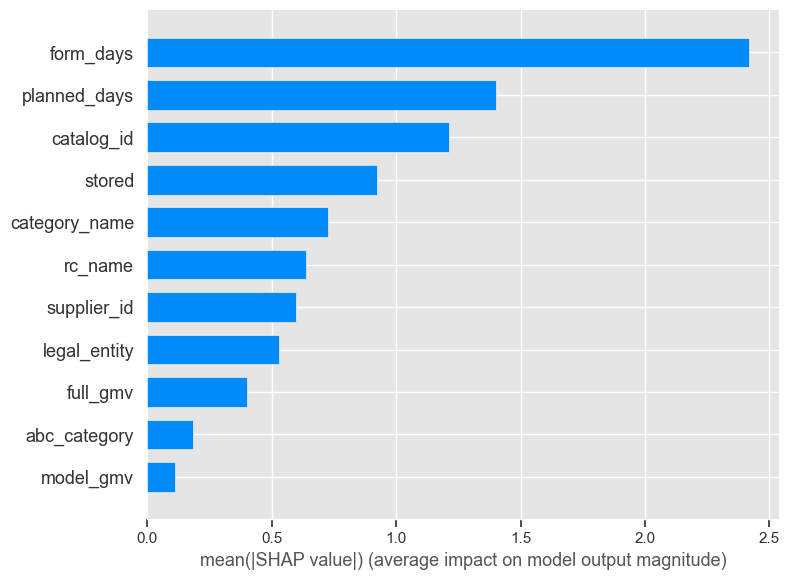

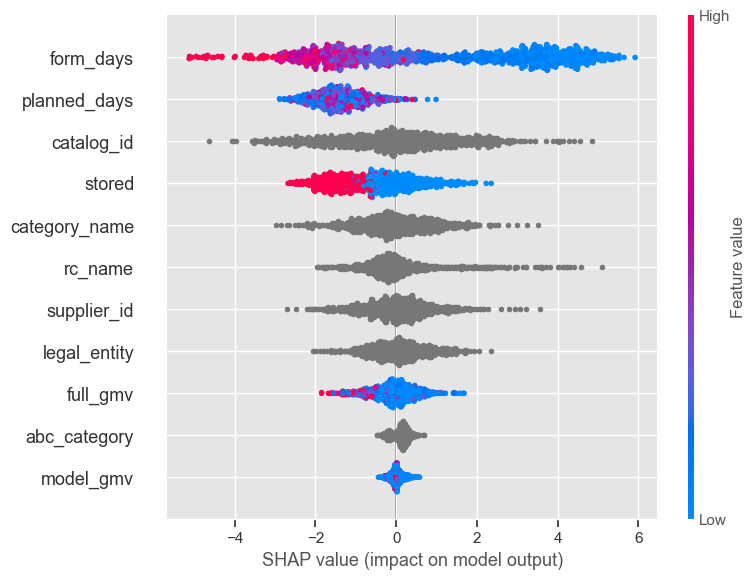

In [42]:
categorical_features = [
    'category_name', 'rc_name', 'legal_entity', 'abc_category', 'catalog_id', 'supplier_id'
]

for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# Получаем лучшую модель
best_model = automl.model.estimator
print(f"🏆 Используемая модель: {type(best_model).__name__}")

# Берём небольшую часть данных для SHAP (чтобы быстро работало)
X_explain = X_test.head(1000).copy()

# Определяем Explainer в зависимости от типа модели
if isinstance(best_model, (lgb.LGBMClassifier, xgb.XGBClassifier, CatBoostClassifier)):
    explainer = shap.TreeExplainer(best_model)

elif isinstance(best_model, LogisticRegression):
    explainer = shap.LinearExplainer(best_model, X_train.head(1000))

else:
    background = shap.kmeans(X_train, 500)
    explainer = shap.KernelExplainer(automl.predict_proba, background)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_explain)

# Если это бинарная классификация и SHAP вернул список, берем второй класс
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1]

# Визуализация: топ фичей (bar plot)
shap.summary_plot(shap_values, X_explain, plot_type="bar")

# Визуализация: влияние фичей на предсказание
shap.summary_plot(shap_values, X_explain)

# Пример влияния фичей на конкретный объект
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_explain.iloc[0, :])

In [43]:
# Целевая переменная
target = 'form_days'

# Признаки
features = [
    'supplier_id', 'catalog_id', 'category_name', 'rc_name', 'legal_entity',
    'model_gmv', 'full_gmv', 'planned_days', 'stored', 'abc_category'
]

In [44]:
# Выбираем нужные колонки
X = df[features].copy()
y = df[target]

# Бинарные признаки → int
X['stored'] = X['stored'].astype(int)

# Список категориальных признаков (БЕЗ stored!)
categorical_features = [
    'supplier_id', 'catalog_id', 'category_name', 
    'rc_name', 'legal_entity', 'abc_category'
]

# Приводим их к типу category
X[categorical_features] = X[categorical_features].astype('category')

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [45]:
# --- 1. Создаем и обучаем модель БЕЗ ExtraTreesRegressor ---
automl = AutoML()


automl.fit(
    X_train, y_train,
    task="regression",
    metric="rmse",
    time_budget=120,
    estimator_list=['lgbm', 'xgboost', 'rf']
)

# --- 2. Предсказания ---
y_pred = automl.predict(X_test)

[flaml.automl.logger: 06-26 23:58:58] {1752} INFO - task = regression
[flaml.automl.logger: 06-26 23:58:58] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-26 23:58:58] {1862} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 06-26 23:58:58] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf']
[flaml.automl.logger: 06-26 23:58:58] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-26 23:58:58] {2417} INFO - Estimated sufficient time budget=279s. Estimated necessary time budget=0s.
[flaml.automl.logger: 06-26 23:58:58] {2466} INFO -  at 0.1s,	estimator lgbm's best error=39.9037,	best estimator lgbm's best error=39.9037
[flaml.automl.logger: 06-26 23:58:58] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-26 23:58:59] {2466} INFO -  at 0.1s,	estimator lgbm's best error=39.9037,	best estimator lgbm's best error=39.9037
[flaml.automl.logger: 06-26 23:58:59] {2282} INFO - iteration 2, current lear

In [48]:
# --- 3. Оценка качества ---
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# --- 4. Вывод лучшей модели ---
print("\n🏆 Лучшая модель:", type(automl.model.estimator).__name__)

MAE: 12.461073663066003
R²: 0.7440264917434698

🏆 Лучшая модель: LGBMRegressor


🏆 Используемая модель: LGBMRegressor


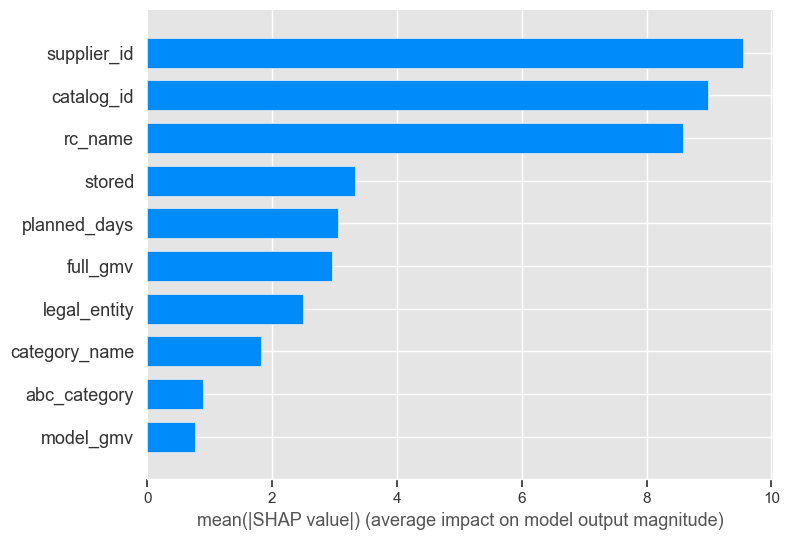

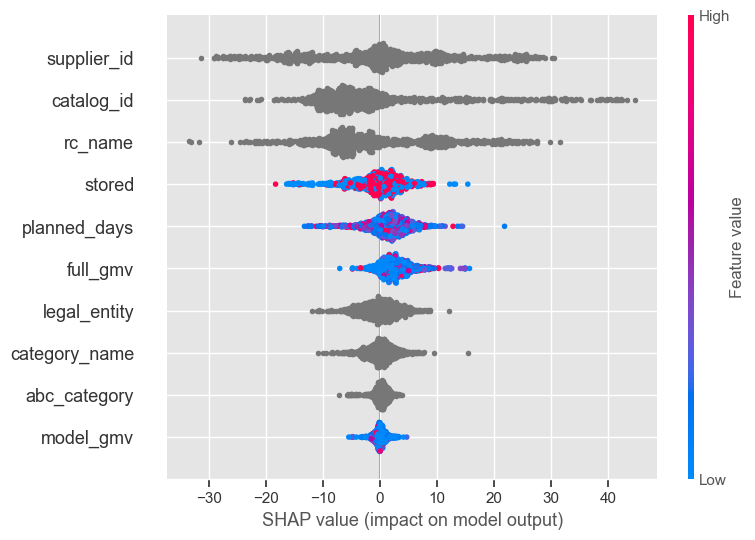

In [51]:
categorical_features = [
    'category_name', 'rc_name', 'legal_entity', 'abc_category', 'catalog_id', 'supplier_id'
]

for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# Получаем лучшую модель из AutoML
best_model = automl.model.estimator  # или просто automl.model
print(f"🏆 Используемая модель: {type(best_model).__name__}")

# Берём небольшую часть данных для SHAP (чтобы быстро работало)
X_explain = X_test.head(1000).copy()

# Определяем Explainer в зависимости от типа модели
if isinstance(best_model, (lgb.LGBMRegressor, xgb.XGBRegressor, CatBoostRegressor)):
    explainer = shap.TreeExplainer(best_model)

elif isinstance(best_model, LinearRegression):
    explainer = shap.LinearExplainer(best_model, X_train.head(1000))

else:
    background = shap.kmeans(X_train, 50)  # уменьшили число бэкграунд-сэмплов для скорости
    explainer = shap.KernelExplainer(automl.predict, background)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_explain)

# Визуализация: топ фичей (bar plot)
shap.summary_plot(shap_values, X_explain, plot_type="bar")

# Визуализация: влияние фичей на предсказание
shap.summary_plot(shap_values, X_explain)

# Пример влияния фичей на конкретный объект
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_explain.iloc[0, :])

# Сегментация поставщиков

In [91]:
# Группируем по поставщику и РЦ
supplier_by_rc = df.groupby(['supplier_id', 'rc_name']).agg(
    avg_delay_days=('delay_days', 'mean'),
    late_rate=('is_late_to_rc_delivered', 'mean'),
    avg_form_days=('form_days', 'mean'),
    total_orders=('id', 'count')
).reset_index()

# Фильтруем только те группы, где есть хотя бы 10 заказов
supplier_by_rc = supplier_by_rc[supplier_by_rc['total_orders'] >= 10]
supplier_by_rc.sort_values(by='total_orders', ascending=False, inplace=True)
supplier_by_rc.head(5)

,supplier_id,rc_name,avg_delay_days,late_rate,avg_form_days,total_orders
27,8,КРС ПЭК,8.556278,0.487964,40.552375,1537
26,8,КРС ЛогЛаб,23.192362,0.570721,41.301273,1414
38,8,ЧЕХ ДЛ,4.995640,0.144622,23.415698,1376
1587,2482,КРС ЛогЛаб,0.553980,0.249015,72.833727,1269
106,19,ЛИП,3.650622,0.435685,104.358506,1205


In [101]:
# Группируем по поставщику и РЦ
supplier_by_rc = df.groupby(['supplier_id', 'rc_name']).agg(
    avg_delay_days=('delay_days', 'mean'),
    late_rate=('is_late_to_rc_delivered', 'mean'),
    avg_form_days=('form_days', 'mean'),
    total_orders=('id', 'count')
).reset_index()

# Фильтруем только те группы, где есть хотя бы 10 заказов
supplier_by_rc = supplier_by_rc[supplier_by_rc['total_orders'] >= 1]

# Создаем первую таблицу для late_rate
late_rate_pivot = supplier_by_rc.pivot_table(
    index='supplier_id',
    columns='rc_name',
    values='late_rate',
    aggfunc='mean'
)

# Создаем вторую таблицу для avg_form_days
avg_form_days_pivot = supplier_by_rc.pivot_table(
    index='supplier_id',
    columns='rc_name',
    values='avg_form_days',
    aggfunc='mean'
)

In [103]:
# Выводим первые 5 строк каждой таблицы
print("Таблица late_rate:")
late_rate_pivot.head()

Таблица late_rate:


rc_name,АЛД ЯТА,АРТЕМ ЭйПиТрейд,Артем ЛогЛаб,ВОЛГ БОМ,ЕКБ ДЛ,Иркутск,КЕМ СКАТ,КРС ЛогЛаб,КРС ПЭК,КРС ТДЛ,...,МАГ ПЭК,МУРМАНСК МЗЧ,НЕВССК СТАР,ПЕРМЬ ПЭК,РЦ Новосибирск ДЛ,РЦ Хабаровск,СПБ-1,Тюмень ГРЗН,ЧЕЛ,ЧЕХ ДЛ
supplier_id,,,,,,,,,,,,,,,,,,,,,
1,0.457143,0.862500,0.521739,0.380952,0.526316,0.312500,0.258621,0.357827,0.203922,NaN,...,0.000000,0.372881,0.417910,0.464286,1.0,0.650000,0.500000,NaN,0.0,0.441441
8,0.715867,0.945205,0.388158,0.265823,0.574713,0.701493,0.574850,0.570721,0.487964,NaN,...,1.000000,0.223561,0.613065,0.169231,1.0,0.826087,0.185841,1.0,1.0,0.144622
9,0.000000,0.250000,0.000000,NaN,NaN,1.000000,0.000000,0.250000,0.666667,NaN,...,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.512821,NaN,NaN,...,NaN,0.962963,NaN,0.444444,NaN,NaN,0.357143,NaN,NaN,0.250000
12,0.800000,1.000000,0.878788,0.888889,0.000000,0.846154,0.312500,0.194030,NaN,NaN,...,0.714286,0.000000,0.711538,0.166667,NaN,0.555556,0.200000,NaN,0.0,0.326087


In [105]:
print("\nТаблица avg_form_days:")
avg_form_days_pivot.head()


Таблица avg_form_days:


rc_name,АЛД ЯТА,АРТЕМ ЭйПиТрейд,Артем ЛогЛаб,ВОЛГ БОМ,ЕКБ ДЛ,Иркутск,КЕМ СКАТ,КРС ЛогЛаб,КРС ПЭК,КРС ТДЛ,...,МАГ ПЭК,МУРМАНСК МЗЧ,НЕВССК СТАР,ПЕРМЬ ПЭК,РЦ Новосибирск ДЛ,РЦ Хабаровск,СПБ-1,Тюмень ГРЗН,ЧЕЛ,ЧЕХ ДЛ
supplier_id,,,,,,,,,,,,,,,,,,,,,
1,68.100000,29.300000,155.000000,7.571429,14.368421,32.093750,52.612069,114.281150,61.458824,NaN,...,2.0,77.677966,36.223881,22.571429,0.0,17.250000,29.125000,NaN,0.0,32.621622
8,55.911439,91.424658,36.578947,12.139241,14.896552,26.880597,24.972056,41.301273,40.552375,NaN,...,0.0,18.552878,18.869347,15.994872,0.0,1.217391,28.924147,0.0,8.0,23.415698
9,0.000000,8.000000,11.333333,NaN,NaN,0.000000,2.400000,4.687500,2.333333,NaN,...,NaN,0.000000,3.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,17.866667,74.769231,NaN,NaN,...,NaN,64.000000,NaN,57.000000,NaN,NaN,29.000000,NaN,NaN,48.000000
12,0.000000,60.923077,67.666667,0.000000,0.000000,0.000000,16.593750,147.955224,NaN,NaN,...,0.0,0.000000,57.942308,29.000000,NaN,8.944444,0.000000,NaN,0.0,11.913043


In [53]:
# Сортировка по late_rate и delay_days для поиска "лучших" и "худших"
top_performers = supplier_by_rc.sort_values(by=['late_rate', 'avg_delay_days'], ascending=[True, True]).head(10)
worst_performers = supplier_by_rc.sort_values(by=['late_rate', 'avg_delay_days'], ascending=[False, False]).head(10)

# Выводим результаты
print("🏆 Лучшие комбинации поставщик + РЦ:")
top_performers

🏆 Лучшие комбинации поставщик + РЦ:


,supplier_id,rc_name,avg_delay_days,late_rate,avg_form_days,total_orders
636,498,НЕВССК СТАР,-50.300000,0.0,59.200000,10
1156,1415,МУРМАНСК МЗЧ,-47.294118,0.0,30.000000,17
1161,1415,ЧЕХ ДЛ,-41.920000,0.0,15.400000,25
1153,1415,КРС ЛогЛаб,-40.537037,0.0,30.851852,54
429,285,КЕМ СКАТ,-35.545455,0.0,3.272727,11
1152,1415,КЕМ СКАТ,-34.861111,0.0,32.777778,36
431,285,ЛИП,-34.767442,0.0,6.837209,86
632,498,КРС ЛогЛаб,-34.523810,0.0,79.809524,42
339,216,МУРМАНСК МЗЧ,-32.066667,0.0,47.800000,15
1157,1415,НЕВССК СТАР,-30.612903,0.0,13.225806,31


In [54]:
print("\n⚠️ Худшие комбинации поставщик + РЦ:")
worst_performers


⚠️ Худшие комбинации поставщик + РЦ:


,supplier_id,rc_name,avg_delay_days,late_rate,avg_form_days,total_orders
29,8,МАГ ПЭК,240.142857,1.0,0.000000,28
835,855,КРС ЛогЛаб,99.583333,1.0,25.500000,12
833,855,Артем ЛогЛаб,88.266667,1.0,145.483333,60
831,855,АЛД ЯТА,82.684211,1.0,31.473684,19
470,304,КЕМ СКАТ,80.523810,1.0,36.190476,21
366,227,ЛИП,79.000000,1.0,28.000000,10
56,12,АРТЕМ ЭйПиТрейд,76.653846,1.0,60.923077,26
472,304,ЛИП,64.846154,1.0,7.384615,13
308,200,ЛИП,63.454545,1.0,8.727273,11
867,914,Иркутск,58.733333,1.0,53.400000,15


In [55]:
# Группируем по поставщику и категории
supplier_by_category = df.groupby(['supplier_id', 'category_name']).agg(
    avg_delay_days=('delay_days', 'mean'),
    late_rate=('is_late_to_rc_delivered', 'mean'),
    avg_form_days=('form_days', 'mean'),
    total_orders=('id', 'count')
).reset_index()

# Фильтруем по количеству заказов
supplier_by_category = supplier_by_category[supplier_by_category['total_orders'] >= 10]
supplier_by_category.sort_values(by='total_orders', ascending=False, inplace=True)
supplier_by_category.head(5)

,supplier_id,category_name,avg_delay_days,late_rate,avg_form_days,total_orders
3944,857,Болты,2.814904,0.510817,72.330529,832
463,8,Папка,13.432266,0.418719,30.141626,812
484,8,Ручка,11.886398,0.399103,30.037369,669
432,8,Маркер,10.751689,0.444257,32.033784,592
1467,128,Болты,6.166311,0.398721,13.588486,469


In [56]:
# Лучшие пары: минимальная доля просрочек и задержка
top_performers_cat = supplier_by_category.sort_values(
    by=['late_rate', 'avg_delay_days'], 
    ascending=[True, True]
).head(10)

# Худшие пары: максимальная доля просрочек и задержка
worst_performers_cat = supplier_by_category.sort_values(
    by=['late_rate', 'avg_delay_days'], 
    ascending=[False, False]
).head(10)

# Вывод
print("🏆 Лучшие комбинации поставщик + категория:")
top_performers_cat

🏆 Лучшие комбинации поставщик + категория:


,supplier_id,category_name,avg_delay_days,late_rate,avg_form_days,total_orders
5078,1415,Фторопласты,-51.473684,0.0,19.947368,19
5060,1415,Клиновые ремни для токарных станков,-50.409091,0.0,30.363636,22
6561,2456,Кнопки управления,-48.827586,0.0,65.862069,29
869,18,Шкаф для инструментов,-43.166667,0.0,39.416667,12
5069,1415,Сальниковые набивки,-37.529412,0.0,15.705882,17
5075,1415,Технические пластины,-36.720000,0.0,21.920000,25
3143,524,Ведро,-33.500000,0.0,49.300000,10
3903,855,Набор шестигранных ключей,-33.142857,0.0,84.000000,14
5068,1415,Рукава напорные,-32.770833,0.0,20.833333,48
3886,855,Зубило кузнечное,-30.545455,0.0,83.090909,11


In [57]:
print("\n⚠️ Худшие комбинации поставщик + категория:")
worst_performers_cat


⚠️ Худшие комбинации поставщик + категория:


,supplier_id,category_name,avg_delay_days,late_rate,avg_form_days,total_orders
3906,855,Напайные пластины,106.818182,1.000000,34.000000,11
3911,855,Пластины токарные,77.416667,1.000000,115.916667,12
1229,82,Комбинированный ключ,46.032258,1.000000,47.129032,31
1223,82,Зубило слесарное,34.700000,1.000000,52.000000,10
5501,1610,Развертки,31.411765,1.000000,0.000000,17
2480,305,Тетради,20.083333,1.000000,52.083333,12
6152,2088,Развертки,14.333333,1.000000,23.333333,12
1277,82,Рожковый ключ,39.513514,0.972973,56.216216,37
4438,914,Муфты и переходники,60.150000,0.950000,22.350000,20
4453,914,Соединители и переходники,46.950000,0.950000,22.800000,20


### **Ключевые выводы:**
1. **Основная проблема выявлена:**  
   Консолидация заказов сама по себе не увеличивает общие задержки доставки. Однако "старые" заказы (те, что долго ждут отправки в консолидированной партии) действительно получают больше задержек.

2. **Критический порог времени сборки грузов:**  
   Если время сборки грузов превышает **6 дней**, резко возрастает риск задержек для "старых" заказов.

3. **Фокус на "старые" заказы:**  
   Проблема касается именно тех заказов, которые долго находятся в очереди на отправку, а не всех заказов в целом.

4. **Влияние параметра на прогноз времени формирования (консолидации подзаказов):**  
   Наибольшее влияние:

   - Поставщик
   - РЦ

   Незначительное влияние:

   - Категория
   - Оборот поставщика   

---

### **Рекомендации для бизнеса:**
1. **Ограничить время сборки грузов до 5 дней.**  
   Это позволит минимизировать задержки для "старых" заказов и улучшить общий уровень сервиса.

In [109]:
from pandas import ExcelWriter

# Укажите путь и имя файла для сохранения
output_file = "supplier_analysis_report.xlsx"

# Создаем ExcelWriter
with ExcelWriter(output_file, engine='openpyxl') as writer:
    # Сохраняем таблицу late_rate на первый лист
    late_rate_pivot.to_excel(writer, sheet_name='Late Rate')
    
    # Сохраняем таблицу avg_form_days на второй лист
    avg_form_days_pivot.to_excel(writer, sheet_name='Avg Form Days')
    
    # Сохраняем final_report на третий лист
    final_report.to_excel(writer, sheet_name='Final Report')

print(f"Отчет успешно сохранен в файл: {output_file}")

Отчет успешно сохранен в файл: supplier_analysis_report.xlsx
